In [1]:
import os
import time
import tqdm
import tempfile
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

### Service Functions

In [2]:
def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                      elevation=10, initial_azimuth=230):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Option Price', rotation=90)
    
    plt.show()

In [3]:
def cpp_asian_option_price(*parameters):
    
    string_parameters = list(map(str, parameters))
    
    arguments = ["cpp_asian/asian", *string_parameters]

    result = subprocess.run(
        arguments,
        stdout=subprocess.PIPE, 
        stderr=subprocess.STDOUT, 
        text=True
    )

    result_lines = result.stdout.splitlines()
    
    asian_price = pick_asian_price(result_lines)

    return asian_price


def pick_asian_price(result_lines):
    
    asian_price_line = [line for line in result_lines
                        if line.startswith("Asian Price")][0]
    
    asian_price = asian_price_line.split()[-1]
    
    return asian_price


def get_cartesian_product(*lists):

    cartesian_product = np.array(np.meshgrid(*lists)).T.reshape(-1, len(lists))
    
    return cartesian_product

In [4]:
# Test C++ code call

# Number of Paths: 100000
# Number of Ints: 250
# Underlying: 30
# Strike: 29
# Risk-Free Rate: 0.08
# Volatility: 0.3
# Maturity: 1
# Asian Price: 2.85425

cpp_asian_option_price(30, 29, 0.08, 0.3, 100000)

'2.84815'

### Dataset Parameters

In [5]:
# 9K Dataset Parameters

initial_stock_prices = np.linspace(10, 200, 20)
strike_prices = np.linspace(10, 200, 11)
risk_free_rates = np.linspace(0.03, 0.1, 8)
volatilities = np.linspace(0.2, 0.6, 5)

dataset_size = 20 * 11 * 8 * 5

print("initial_stock_prices:", initial_stock_prices)
print("strike_prices:", strike_prices)
print("risk_free_rates:", risk_free_rates)
print("volatilities:", volatilities)

print("dataset_size:", dataset_size)

initial_stock_prices: [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200.]
strike_prices: [ 10.  29.  48.  67.  86. 105. 124. 143. 162. 181. 200.]
risk_free_rates: [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
volatilities: [0.2 0.3 0.4 0.5 0.6]
dataset_size: 8800


In [6]:
# 1K Test Dataset Parameters

initial_stock_prices = sorted(100 * np.random.lognormal(0.5, 0.25, size=5))
strike_prices = sorted(70 * np.random.lognormal(0.5, 0.25, size=5))

risk_free_rates = np.linspace(0.03, 0.1, 8)
volatilities = np.linspace(0.2, 0.6, 5)

pathes_count = 1000000
dataset_size = 5 * 5 * 8 * 5

# print("initial_stock_prices:", initial_stock_prices)
# print("strike_prices:", strike_prices)
print("risk_free_rates:", risk_free_rates)
print("volatilities:", volatilities)

print("dataset_size:", dataset_size)

risk_free_rates: [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
volatilities: [0.2 0.3 0.4 0.5 0.6]
dataset_size: 1000


In [7]:
# 36 Test Dataset Parameters

initial_stock_prices = sorted(np.linspace(10, 50, 3))
strike_prices = sorted(np.linspace(10, 48, 3))

risk_free_rates = np.linspace(0.03, 0.1, 2)
volatilities = np.linspace(0.2, 0.6, 2)

pathes_count = 1000000
dataset_size = 3 * 3 * 2 * 2

print("initial_stock_prices:", initial_stock_prices)
print("strike_prices:", strike_prices)
print("risk_free_rates:", risk_free_rates)
print("volatilities:", volatilities)

print("dataset_size:", dataset_size)

initial_stock_prices: [10.0, 30.0, 50.0]
strike_prices: [10.0, 29.0, 48.0]
risk_free_rates: [0.03 0.1 ]
volatilities: [0.2 0.6]
dataset_size: 36


In [57]:
# Sparse Dataset Parameters

INITIAL_STOCK_PRICES_COUNT = 100
STRIKE_PRICES_COUNT = 100

RISK_FREE_RATES_COUNT = 1
VOLATILITIES_COUNT = 5

DENSITY = 0.1

initial_stock_prices_samples_count = int(DENSITY * INITIAL_STOCK_PRICES_COUNT)
strike_prices_samples_count = int(DENSITY * STRIKE_PRICES_COUNT)

initial_stock_prices = np.random.lognormal(0.5, 0.25, size=INITIAL_STOCK_PRICES_COUNT)
initial_stock_prices = np.random.choice(initial_stock_prices,
                                        size=initial_stock_prices_samples_count,
                                        replace=False)
initial_stock_prices = 100 * initial_stock_prices
initial_stock_prices = np.sort(initial_stock_prices)
initial_stock_prices = initial_stock_prices - initial_stock_prices.min()

strike_prices = np.random.lognormal(0.5, 0.25, size=STRIKE_PRICES_COUNT)
strike_prices = np.random.choice(strike_prices,
                                 size=strike_prices_samples_count,
                                 replace=False)
strike_prices = 70 * strike_prices
strike_prices = np.sort(strike_prices)
strike_prices = strike_prices - strike_prices.min()

# risk_free_rates = np.linspace(0.03, 0.1, RISK_FREE_RATES_COUNT)
risk_free_rates = np.linspace(0.08, 0.08, RISK_FREE_RATES_COUNT)
volatilities = np.linspace(0.2, 0.6, VOLATILITIES_COUNT)


dataset_size = initial_stock_prices_samples_count * strike_prices_samples_count
dataset_size *= RISK_FREE_RATES_COUNT * VOLATILITIES_COUNT

In [63]:
PATHES_COUNT = 1000000

DATASET_FILE = 'generated_prices/asian_smooth_validation_1M_pathes.csv'

print("INITIAL_STOCK_PRICES_COUNT:", INITIAL_STOCK_PRICES_COUNT)
print("STRIKE_PRICES_COUNT:", STRIKE_PRICES_COUNT)
print("DENSITY:", DENSITY)

print("initial_stock_prices_samples_count:", initial_stock_prices_samples_count)
print("strike_prices_samples_count:", strike_prices_samples_count)

print("risk_free_rates:", risk_free_rates)
print("volatilities:", volatilities)

print("PATHES_COUNT:", PATHES_COUNT)
print("dataset_size:", dataset_size)

INITIAL_STOCK_PRICES_COUNT: 100
STRIKE_PRICES_COUNT: 100
DENSITY: 0.1
initial_stock_prices_samples_count: 10
strike_prices_samples_count: 10
risk_free_rates: [0.08]
volatilities: [0.2 0.3 0.4 0.5 0.6]
PATHES_COUNT: 1000000
dataset_size: 500


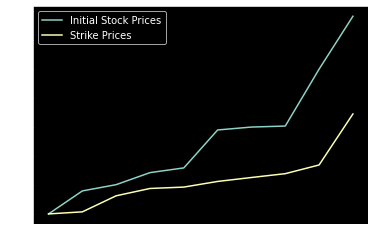

In [64]:
plt.plot(initial_stock_prices, label="Initial Stock Prices")
plt.plot(strike_prices, label="Strike Prices")
plt.legend();

In [60]:
# Compose Parameters Meshgrid

parameters_meshgrid = get_cartesian_product(
    initial_stock_prices, 
    strike_prices, 
    risk_free_rates, 
    volatilities,
    [PATHES_COUNT]
)

parameters_meshgrid.shape

# get_cartesian_product([1, 2], [0.1, 0.2, 0.3], [0.01, 0.02, 0.03, 0.04])
# np.array(np.meshgrid([1, 2], [0.1, 0.2, 0.3], [0.01, 0.02, 0.03, 0.04])).T.reshape(-1, 3)

(500, 5)

In [61]:
# Select part of Parameters Meshgrid

parameters_meshgrid_selected = parameters_meshgrid[:]

### Run Generation

In [62]:
BATCH_SIZE = 10

batch_count = len(parameters_meshgrid_selected) // BATCH_SIZE

np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,strike_price,risk_free_rate,volatility,option_price',
           comments='')

batch_tracker = tqdm.tqdm(
    range(batch_count),
    desc=f"Generating",
    ncols=110,
    unit='batch',
    # mininterval=1    
    )    

for batch_id in batch_tracker:
    
    queue = []
    results = []
    
    parameters_meshgrid_part = parameters_meshgrid_selected[batch_id * BATCH_SIZE : 
                                                            batch_id * BATCH_SIZE + BATCH_SIZE]

    for experiment_id, parameters in enumerate(parameters_meshgrid_part):

        string_parameters = list(map(str, parameters))

        temporary_file = tempfile.TemporaryFile()

        process = subprocess.Popen(["cpp_asian/asian", 
                                    *string_parameters],
                                   stdout=temporary_file)

        queue.append((experiment_id, process, temporary_file))

    for experiment_id, process, temporary_file in queue:

        process.wait()
        temporary_file.seek(0)

        byte_line = temporary_file.read()

        temporary_file.close()


        result_lines = byte_line.decode('utf-8').splitlines()

        asian_price = pick_asian_price(result_lines)

        parameters = parameters_meshgrid_part[experiment_id]
        
        initial_stock_price, strike_price, risk_free_rate, volatility, pathes_count = parameters
        
        results.append([initial_stock_price, 
                        strike_price, 
                        risk_free_rate, 
                        volatility, 
                        asian_price])

        # print("experiment_id:", experiment_id)
        # print("result_lines:", result_lines)
        # print("asian_price:", asian_price)
        # print("parameters:", parameters)

    # print("results:", results)
    
    with open(DATASET_FILE, 'ab') as dataset_file:
        np.savetxt(dataset_file, results, fmt='%s', delimiter=',')

Generating: 100%|██████████████████████████████████████████████████████████| 50/50 [21:41<00:00, 26.02s/batch]


### Plot

In [65]:
# Compose Option Prices Meshgrid

SELECTED_STRIKE_PRICE = strike_prices[-1]
SELECTED_RISK_FREE_RATE = risk_free_rates[-1]


loaded_records = np.genfromtxt(DATASET_FILE, delimiter=',')[1:]

option_prices_meshgrid_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_meshgrid_shape)


for record in loaded_records:

    initial_stock_price, strike_price, risk_free_rate, volatility, option_price = record
    
    if strike_price == SELECTED_STRIKE_PRICE and risk_free_rate == SELECTED_RISK_FREE_RATE:
        
        initial_stock_price_index = np.where(initial_stock_prices == initial_stock_price)[0][0]
        volatility_index = np.where(volatilities == volatility)[0][0]
        
        # print("initial_stock_price_index:", initial_stock_price_index)
        # print("volatility_index:", volatility_index)
    
        option_prices_meshgrid[initial_stock_price_index, volatility_index] = option_price
        
        # print(record)

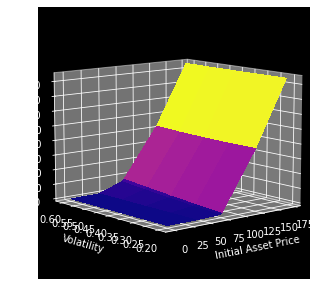

In [66]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid)

### Variance

0.00015225948969759993
1.5630011585599987e-05


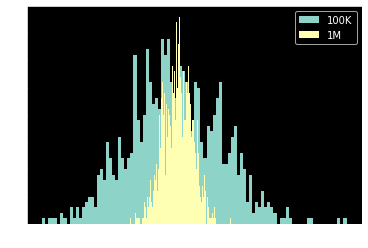

In [30]:
variance_100K_records = np.genfromtxt('generated_prices/asian_option_prices_variance_100K.csv', delimiter=',')[1:]
variance_1M_records = np.genfromtxt('generated_prices/asian_option_prices_variance_1M.csv', delimiter=',')[1:]

print(np.var(variance_100K_records[:, -1]))
print(np.var(variance_1M_records[:, -1]))

plt.hist(variance_100K_records[:, -1], bins=100, label="100K")
plt.hist(variance_1M_records[:, -1], bins=100, label="1M")
plt.legend();

In [ ]:
# initial_stock_prices = jnp.array([1000, 5000])

initial_stock_prices = np.linspace(0, 10000, 11)

# volatilities = np.linspace(0, 1.0, 101)


start_time = time.time()

vmapped_monte_carlo = jax.vmap(jax_monte_carlo,
                               # static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_vmapped_result = vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_vmapped_result.shape:", evaluated_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_vmapped_result.shape: (11, 100000)
duration: 0.99 s.


In [ ]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(jitted_monte_carlo,
                               # static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_vmapped_result = vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_vmapped_result.shape:", evaluated_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_vmapped_result.shape: (11, 100000)
duration: 0.37 s.


In [30]:
# initial_stock_prices = jnp.array([1000, 5000])

initial_stock_prices = np.linspace(0, 10000, 11)

# volatilities = np.linspace(0, 1.0, 101)


start_time = time.time()

pmapped_monte_carlo = jax.pmap(jax_monte_carlo,
                               static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result.shape:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result.shape: (11, 100000)
duration: 7.83 s.


In [32]:
start_time = time.time()

pmapped_monte_carlo = jax.pmap(jitted_monte_carlo,
                               static_broadcasted_argnums=(6, 7, 8),
                               in_axes=(0, None, None, None, None, None, None, None, None, None))

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatility, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_key
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result.shape:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result.shape: (11, 100000)
duration: 0.24 s.


In [49]:
samples_count = 10000

STOCK_PRICE_STEPS = 16
VOLATILITY_STEPS = 16

initial_stock_prices = np.linspace(0, 10000, STOCK_PRICE_STEPS)

volatilities = np.linspace(0, 1.0, VOLATILITY_STEPS)

initial_stock_prices_count = len(initial_stock_prices)
volatilities_count = len(volatilities)


# Randomization Keys

random_seed = np.random.randint(1000)

initial_randomization_key = jax.random.PRNGKey(seed=random_seed)

keys_count = volatilities_count * initial_stock_prices_count

randomization_keys_vector = jax.random.split(initial_randomization_key, keys_count)

randomization_keys = randomization_keys_vector.reshape(volatilities_count, 
                                                       initial_stock_prices_count, 2)

In [ ]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

second_vmapped_monte_carlo = jax.vmap(
    vmapped_monte_carlo,
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

second_vmapped_result = second_vmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_second_vmapped_result = second_vmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_second_vmapped_result.shape:", evaluated_second_vmapped_result.shape)

print(f"duration: {duration:.02f} s.")

2023-01-30 13:25:27.955411: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 57.22GiB (rounded to 61440000000)requested by op 
2023-01-30 13:25:27.955650: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-01-30 13:25:27.955812: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2163] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 61440000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.0KiB
              constant allocation:         0B
        maybe_live_out allocation:   57.22GiB
     preallocated temp allocation:  143.05GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  200.27GiB
              total

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 61440000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.0KiB
              constant allocation:         0B
        maybe_live_out allocation:   57.22GiB
     preallocated temp allocation:  143.05GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  200.27GiB
              total fragmentation:   28.61GiB (14.29%)
Peak buffers:
	Buffer 1:
		Size: 57.22GiB
		Operator: op_name="jit(_normal)/jit(main)/mul" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: f64[16,16,100000,300]
		==========================

	Buffer 2:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: u32[16,16,30000000]
		==========================

	Buffer 3:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: u32[16,16,30000000]
		==========================

	Buffer 4:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 5:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 6:
		Size: 28.61GiB
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: u32[16,16,30000000]
		==========================

	Buffer 7:
		Size: 2.0KiB
		Entry Parameter Subshape: u32[16,16,2]
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: custom-call
		Shape: (u32[16,16,30000000], u32[16,16,30000000])
		==========================

	Buffer 9:
		Size: 16B
		Operator: op_name="jit(_normal)/jit(main)/threefry2x32" source_file="/tmp/ipykernel_161663/627013869.py" source_line=12
		XLA Label: fusion
		Shape: (u32[16,16,30000000], u32[16,16,30000000])
		==========================



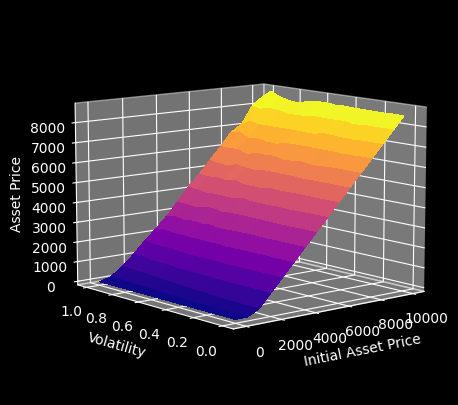

In [38]:
plot_asset_prices(initial_stock_prices, volatilities, evaluated_second_vmapped_result.T)

In [ ]:
start_time = time.time()

vmapped_monte_carlo = jax.vmap(
    jax_monte_carlo_mean,
    # jitted_monte_carlo_mean,
    in_axes=(0, None, None, None, None, None, None, None, None, 0)
)

pmapped_monte_carlo = jax.pmap(
    vmapped_monte_carlo,
    static_broadcasted_argnums=(6, 7, 8),
    in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

pmapped_result = pmapped_monte_carlo(
    
    initial_stock_prices, 
    strike_price,
    time_to_maturity, 
    risk_free_interest_rate,
    dividend_rate, 
    volatilities, 
    option_type, 
    time_steps_count,
    samples_count,
    randomization_keys
    
)

evaluated_pmapped_result = pmapped_result * 1

end_time = time.time()

duration = end_time - start_time

print("evaluated_pmapped_result:", evaluated_pmapped_result.shape)

print(f"duration: {duration:.02f} s.")

evaluated_pmapped_result: (16, 16)
duration: 0.26 s.


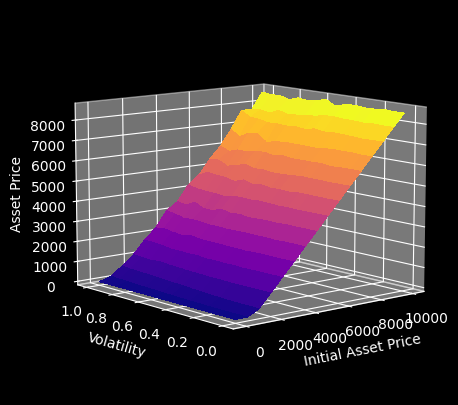

In [ ]:
plot_asset_prices(initial_stock_prices, volatilities, evaluated_pmapped_result.T)

In [ ]:
start_time = time.time()

classical_results = np.zeros(shape=(len(initial_stock_prices),
                                    len(volatilities)))

for volatility_index, volatility in enumerate(volatilities):
    
    # print("volatility:", volatility)
    
    for initial_stock_price_index, initial_stock_price in enumerate(initial_stock_prices):
        
        # print("  initial_stock_price:", initial_stock_price)
        
        # continue

        classical_result = classical_monte_carlo_mean(

            initial_stock_price, 
            strike_price,
            time_to_maturity, 
            risk_free_interest_rate,
            dividend_rate, 
            volatility, 
            option_type, 
            time_steps_count,
            samples_count

        )
        
        classical_results[initial_stock_price_index, volatility_index] = classical_result
        
    elapsed_time = time.time() - start_time

    # print(f"elapsed_time: {elapsed_time:.02f} s.")
        

end_time = time.time()

duration = end_time - start_time

print("classical_results:", classical_results.shape)

print(f"duration: {duration:.02f} s.")

classical_results: (16, 16)
duration: 8.39 s.


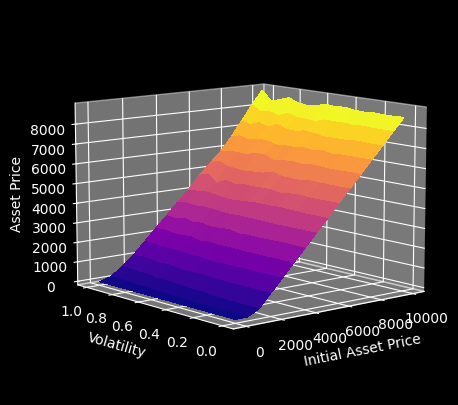

In [47]:
plot_asset_prices(initial_stock_prices, volatilities, classical_results)

In [12]:
def test_function(a, b, c):
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = (0, None, 0))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

result = vmapped_test_function(a_s, b_s, c_s)

print("Result:", result)

Result: [110 211]


In [13]:
def test_function(arguments):
    
    a, b, c = arguments.values()
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = ({'a': 0, 'b': None, 'c': 0},))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

arguments = {'a': a_s, 'b': b_s, 'c': c_s}

result = vmapped_test_function(arguments)

print("Result:", result)

Result: [110 211]


In [ ]:
vmapped_mc = jax.vmap(monte_carlo,
                      in_axes=(0, None, None, None, None, None, None, None, None))

initial_stock_prices = jnp.array([1000, 2000])
strike_price = 100
volatility = 0.5

result = vmapped_mc(S=initial_stock_prices, 
                     K=strike_price,
                     T=time_to_maturity, 
                     r=risk_free_interest_rate,
                     q=dividend_rate, 
                     sigma=volatility, 
                     CallPut=option_type, 
                     n=time_steps_count,
                     m=paths_count)

print("Result:", result)

# ,
                                # axis_name='filters',
                                # static_broadcasted_argnums=[2, 3, 4, 6, 7, 8],
                                # in_axes=(None, 0, None),
                               # )
    
#     result = vmapped_function()
    
#     result = vmapped_function(S=initial_stock_prices, 
#                                   K=strike_prices,
#                                   T=time_to_maturity, 
#                                   r=risk_free_interest_rate,
#                                   q=dividend_rate, 
#                                   sigma=volatilities, 
#                                   CallPut=option_type, 
#                                   n=time_steps_count,
#                                   m=paths_count)
    
#     continue

In [ ]:
def arithmetic_asian_option_price_vectorized(
    initial_stock_price, strike_price, time_to_maturity,
    risk_free_interest_rate,
    volatility, option_type, time_steps_count, samples_count):
    
    # rate_difference = risk_free_interest_rate - dividend_rate
    
    sims = np.zeros(samples_count)
    t = np.linspace(0, time_to_maturity, time_steps_count + 1)
    
    # print("t:", t)
    
    # Stock prices
    
    time_step = time_to_maturity/time_steps_count
    
    for i in range(samples_count):
        
        W = [0] + list(np.random.standard_normal(size=time_steps_count))
        
        W = np.cumsum(W) * np.sqrt(time_step)
        
        St = initial_stock_price * np.exp((risk_free_interest_rate - 0.5 * volatility ** 2) * t 
                                          - volatility * W)
        
        sims[i] = np.sum(St)
        

#     weights = np.random.standard_normal(size=(samples_count, time_steps_count))

#     zeros = np.zeros(shape=(samples_count, 1))

#     stuffed_weights = np.hstack((zeros, weights))

#     samples = np.cumsum(stuffed_weights, axis=1) * np.sqrt(time_step)
        
    sims = sims/(time_steps_count + 1)
    
    # Option prices
    
    price_differences = sims - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences = np.clip(price_differences, a_min=0, a_max=None)
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
    
    return option_prices

In [ ]:
def process_queue():
    
    parameters_meshgrid_initial = parameters_meshgrid[:1000].tolist()

    DATASET_FILE = 'generated_prices/asian_option_prices.csv'

    QUEUE_SIZE = 10

    np.savetxt(DATASET_FILE, [],
               header='initial_stock_price,strike_price,risk_free_rate,volatility,option_price',
               comments='')

    record_tracker = tqdm.tqdm(
        parameters_meshgrid_initial,
        desc=f"Generating",
        ncols=110,
        unit='record',
        mininterval=1    
        )

    queue = []
    results = []

    is_initial_step = True

    while queue or is_initial_step:

        is_initial_step = False

        while (len(queue) < QUEUE_SIZE) and parameters_meshgrid_initial:

            parameters = parameters_meshgrid_initial.pop()

            record_tracker.update(n=1)

            string_parameters = list(map(str, parameters))

            temporary_file = tempfile.TemporaryFile()

            process = subprocess.Popen(["cpp_asian/asian", 
                                        *string_parameters],
                                       stdout=temporary_file)

            queue.append((process, parameters, temporary_file))

            # print("push len(queue):", len(queue))


        process, parameters, temporary_file = queue.pop()  

        process.wait()
        temporary_file.seek(0)

        byte_line = temporary_file.read()

        temporary_file.close()


        result_lines = byte_line.decode('utf-8').splitlines()

        asian_price = pick_asian_price(result_lines)

        initial_stock_price, strike_price, risk_free_rate, volatility, pathes_count = parameters

        results.append([initial_stock_price, 
                        strike_price, 
                        risk_free_rate, 
                        volatility, 
                        asian_price])

        # print("result_lines:", result_lines)
        # print("asian_price:", asian_price)
        # print("parameters:", parameters)

        # print("pop len(queue):", len(queue))


    with open(DATASET_FILE, 'ab') as dataset_file:
        np.savetxt(dataset_file, results, fmt='%s', delimiter=',')